In [23]:
try:
  %tensorflow_version 2.x
except:
  pass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GlobalMaxPool1D, Conv1D, Dense

# Import data

In [2]:
df = pd.read_csv('../large_data/sms-spam/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [59]:
lbl2idx = {'ham': 0, 'spam':1}
idx2lbl = dict(zip(lbl2idx.values(), lbl2idx.keys()))

X = df.v2.values
y = df.v1.map(lbl2idx).values

In [60]:
# First split into train and test, then fit the tokenizer to train data only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

In [61]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

In [62]:
# Pad train data
x_train = pad_sequences(x_train)
x_train.shape

(4457, 189)

In [63]:
# Vocabulary size and sequence length
V = 1 + len(tokenizer.index_word)  # +1 includes index 0, used for padding
T = x_train.shape[1]
print(f"Vocabulary size: {V}")
print(f"Sequence length: {T}")

Vocabulary size: 7966
Sequence length: 189


In [64]:
# Pad test data
x_test = pad_sequences(x_test, maxlen=T)
x_test.shape

(1115, 189)

# Spam detection with RNN 

In [17]:
D = 20  # embedding dim

i = Input(shape=(T, ))
x = i
x = Embedding(input_dim=V, output_dim=D)(x)
x = LSTM(15, activation='relu', return_sequences=True)(x)
x = GlobalMaxPool1D()(x)  # pool over sequence length T (for each LSTM unit)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 162, 20)           159680    
_________________________________________________________________
lstm_1 (LSTM)                (None, 162, 15)           2160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 161,856
Trainable params: 161,856
Non-trainable params: 0
_________________________________________________________________


In [18]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 13s 3ms/sample - loss: 0.4930 - accuracy: 0.8607 - val_loss: 0.3988 - val_accuracy: 0.8664
Epoch 2/10
4457/4457 [==============================] - 12s 3ms/sample - loss: 140106675.3584 - accuracy: 0.8894 - val_loss: 0.2693 - val_accuracy: 0.9435
Epoch 3/10
4457/4457 [==============================] - 11s 3ms/sample - loss: 0.2235 - accuracy: 0.9643 - val_loss: 0.1954 - val_accuracy: 0.9686
Epoch 4/10
4457/4457 [==============================] - 12s 3ms/sample - loss: 60.1434 - accuracy: 0.9749 - val_loss: 0.1516 - val_accuracy: 0.9731
Epoch 5/10
4457/4457 [==============================] - 13s 3ms/sample - loss: 19.4170 - accuracy: 0.9789 - val_loss: 0.1217 - val_accuracy: 0.9749
Epoch 6/10
4457/4457 [==============================] - 12s 3ms/sample - loss: 0.7812 - accuracy: 0.9838 - val_loss: 0.0990 - val_accuracy: 0.9767
Epoch 7/10
4457/4457 [==============================] - 11s 

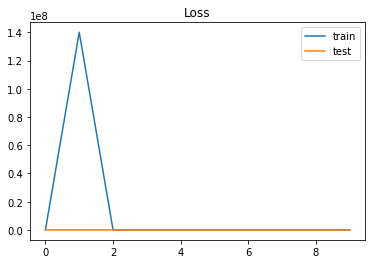

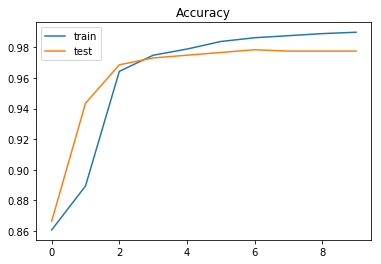

In [21]:
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(r.history['accuracy'], label='train')
plt.plot(r.history['val_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show()

# Spam detection with CNN 

In [77]:
D = 20  # embedding_dim

i = Input(shape=(T, ))
x = i
x = Embedding(input_dim=V, output_dim=D)(x)
x = Conv1D(15, kernel_size=2, strides=2, padding='same')(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [78]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 189, 20)           159320    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 95, 15)            615       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 159,951
Trainable params: 159,951
Non-trainable params: 0
_________________________________________________________________


In [79]:
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 2s 349us/sample - loss: 0.4693 - accuracy: 0.8622 - val_loss: 0.3588 - val_accuracy: 0.8628
Epoch 2/10
4457/4457 [==============================] - 1s 145us/sample - loss: 0.2639 - accuracy: 0.8896 - val_loss: 0.1697 - val_accuracy: 0.9435
Epoch 3/10
4457/4457 [==============================] - 1s 140us/sample - loss: 0.1075 - accuracy: 0.9652 - val_loss: 0.0899 - val_accuracy: 0.9731
Epoch 4/10
4457/4457 [==============================] - 1s 150us/sample - loss: 0.0536 - accuracy: 0.9836 - val_loss: 0.0689 - val_accuracy: 0.9776
Epoch 5/10
4457/4457 [==============================] - 1s 149us/sample - loss: 0.0318 - accuracy: 0.9910 - val_loss: 0.0571 - val_accuracy: 0.9785
Epoch 6/10
4457/4457 [==============================] - 1s 149us/sample - loss: 0.0203 - accuracy: 0.9957 - val_loss: 0.0505 - val_accuracy: 0.9812
Epoch 7/10
4457/4457 [==============================] - 1s 152us

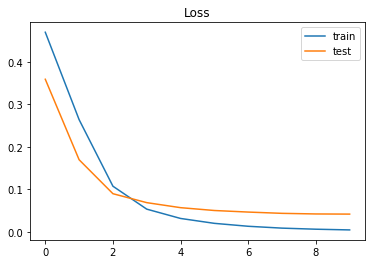

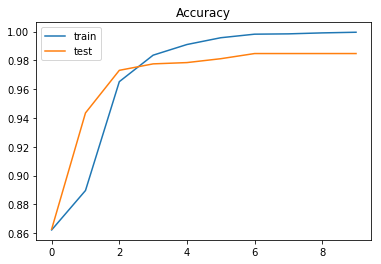

In [81]:
plt.plot(r.history['loss'], label='train')
plt.plot(r.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(r.history['accuracy'], label='train')
plt.plot(r.history['val_accuracy'], label='test')
plt.legend()
plt.title('Accuracy')
plt.show()

In [101]:
# Check wrong results
p_test = np.argmax(model.predict(x_test), axis=1)
misclassified = np.where(p_test != y_test)[0]
for i in np.random.choice(misclassified, size=len(misclassified)):
  print(f"\nPredicted {idx2lbl[p_test[i]]}, true {idx2lbl[y_test[i]]}:")
  print(f"{X_test[i]}")
  answer = input("Continue? (Y/n): ")
  if answer == "n": break


Predicted ham, true spam:
YOU 07801543489 are guaranteed the latests Nokia Phone, a 40GB iPod MP3 player or a å£500 prize! Txt word:COLLECT to No:83355! TC-LLC NY-USA 150p/Mt msgrcvd18+
Continue? (Y/n): Y

Predicted ham, true spam:
RGENT! This is the 2nd attempt to contact U!U have WON å£1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. maxå£7. 50
Continue? (Y/n): Y

Predicted ham, true spam:
Well done ENGLAND! Get the official poly ringtone or colour flag on yer mobile! text TONE or FLAG to 84199 NOW! Opt-out txt ENG STOP. Box39822 W111WX å£1.50
Continue? (Y/n): Y

Predicted ham, true spam:
December only! Had your mobile 11mths+? You are entitled to update to the latest colour camera mobile for Free! Call The Mobile Update Co FREE on 08002986906
Continue? (Y/n): n
